Installing the required libraries

In [ ]:
pip install autogluon==1.1.1 pip install autogluon==1.1.1 numpy==1.24.4  scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4

  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached triton-2.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.4 kB)
Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl (779.1 MB)
Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
Using cached triton-2.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (168.1 MB)
  Attempting uninstall: triton
    Found existing installation: triton 3.0.0
    Uninstalling triton-3.0.0:
      Successfully uninstalled triton-3.0.0
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.1.0.70
    Uninstalling nvidia-cudnn-cu12-9.1.0.70:
      Successfully uninstalled nvidia-cudnn-cu12-9.1.0.70
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0
    Uninstalling torch-2.4.0:
      Successful

In [ ]:
pip install -U torch torchaudio --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 136.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 217.9 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.1
    Uninstalling triton-2.3.1:
      Successfully uninstalled triton-2.3.1
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 8.9.2.26
    Uninstalling nvidia-cudnn-cu12-8.9.2.26:
      Successfully uninstalled nvidia-cudnn-cu12-8.9.2.26
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires torch<2.4,>=2.2, but you have torch 2.

Importing libraries and load AirPassenger Data set.

In [ ]:
import autogluon
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from autogluon.timeseries.models import WaveNetModel
import pandas as pd

# To load local csv  > modify to the right path where the file is present
Y_df = pd.read_csv('AirPassengersDataset.csv')
Y_df = Y_df.reset_index(drop=True)


Define calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Converting date field to datetime format and renaming columns to required format

In [ ]:

Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df.rename(columns={"ds":"timestamp","unique_id" :"item_id", "y": "target"},inplace = True)
Y_df['item_id'] = 'airline_1'
Y_df.head()

,item_id,timestamp,target
0,airline_1,1949-01-31,112
1,airline_1,1949-02-28,118
2,airline_1,1949-03-31,132
3,airline_1,1949-04-30,129
4,airline_1,1949-05-31,121


AutoGluon expects time series data in long format. Each row of the data frame contains a single observation (timestep) of a single time series represented by

unique ID of the time series ("**item_id**") as int or str

timestamp of the observation ("**timestamp**") as a pandas.Timestamp or compatible format

numeric value of the time series ("**target**")

In [ ]:
data = TimeSeriesDataFrame.from_data_frame(
    Y_df,
    id_column="item_id",
    timestamp_column="timestamp"
)
data.tail()

target
item_id   timestamp         
airline_1 1960-08-31     606
          1960-09-30     508
          1960-10-31     461
          1960-11-30     390
          1960-12-31     432

Split data into **train** and **test**

In [ ]:
train_data = data.head(132)
test_data = data.tail(12)

Create a **TimeSeriesPredictor** object to forecast future values and explicitly define "**chronos_large_ensemble**" to be used

In [ ]:
prediction_length =12
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
train_data, presets="chronos_large_ensemble"
)

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240827_230909'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       11.26 GB / 12.67 GB (88.8%)
Disk Space Avail:   65.38 GB / 107.72 GB (60.7%)
Setting presets to: chronos_large_ensemble

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'batch_size': 8, 'model_path': 'large'},
                     'DirectTabular': {},
                     'PatchTST': {},
                     'RecursiveTabular': {},
                     'SeasonalNaive': {},
                     'TemporalFusionTransformer': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4

Predict for the next defined horizon

In [ ]:
predictions = predictor.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: RecursiveTabular


In [ ]:
predictions

mean         0.1         0.2         0.3  \
item_id   timestamp                                                    
airline_1 1960-01-31  409.050995  390.085909  396.596233  401.290635   
          1960-02-29  388.893677  362.072995  371.279984  377.918871   
          1960-03-31  453.047974  420.199481  431.475694  439.606637   
          1960-04-30  444.603302  406.673130  419.693779  429.082583   
          1960-05-31  467.213440  424.806218  439.363746  449.860749   
          1960-06-30  528.337036  481.882252  497.829225  509.328115   
          1960-07-31  604.175415  553.998514  571.223213  583.643434   
          1960-08-31  612.484985  558.843621  577.257600  590.535374   
          1960-09-30  512.675598  455.780340  475.311313  489.394520   
          1960-10-31  454.367310  394.394441  414.981895  429.826898   
          1960-11-30  409.367310  346.467235  368.059539  383.629109   
          1960-12-31  452.367310  386.670324  409.222750  425.484636   

                             0.4         0.5         0.6         0.7  \
item_id   timestamp                                                    
airline_1 1960-01-31  405.301829  409.050995  412.800161  416.811354   
          1960-02-29  383.591555  388.893677  394.195798  399.868482   
          1960-03-31  446.554228  453.047974  459.541720  466.489311   
          1960-04-30  437.104970  444.603302  452.101634  460.124021   
          1960-05-31  458.830050  467.213440  475.596830  484.566131   
          1960-06-30  519.153492  528.337036  537.520580  547.345957   
          1960-07-31  594.256054  604.175415  614.094776  624.707396   
          1960-08-31  601.880742  612.484985  623.089228  634.434597   
          1960-09-30  501.428100  512.675598  523.923096  535.956677   
          1960-10-31  442.511405  454.367310  466.223214  478.907721   
          1960-11-30  396.932732  409.367310  421.801887  435.105510   
          1960-12-31  439.379817  452.367310  465.354802  479.249984   

                             0.8         0.9  
item_id   timestamp                           
airline_1 1960-01-31  421.505756  428.016081  
          1960-02-29  406.507369  415.714359  
          1960-03-31  474.620253  485.896466  
          1960-04-30  469.512825  482.533474  
          1960-05-31  495.063133  509.620662  
          1960-06-30  558.844847  574.791820  
          1960-07-31  637.127617  654.352317  
          1960-08-31  647.712371  666.126349  
          1960-09-30  550.039883  569.570857  
          1960-10-31  493.752724  514.340178  
          1960-11-30  450.675081  472.267384  
          1960-12-31  495.511869  518.064295

Measure the models accuracy

In [ ]:
calculate_error_metrics(test_data['target'],predictions['mean']['airline_1'])

MSE : 231.54919850407168
RMSE : 15.216740731972523
MAPE : 0.02696902830021881
r2 : 0.9582001336562018
adjusted_r2 : 0.954020147021822


Visualize the predictions

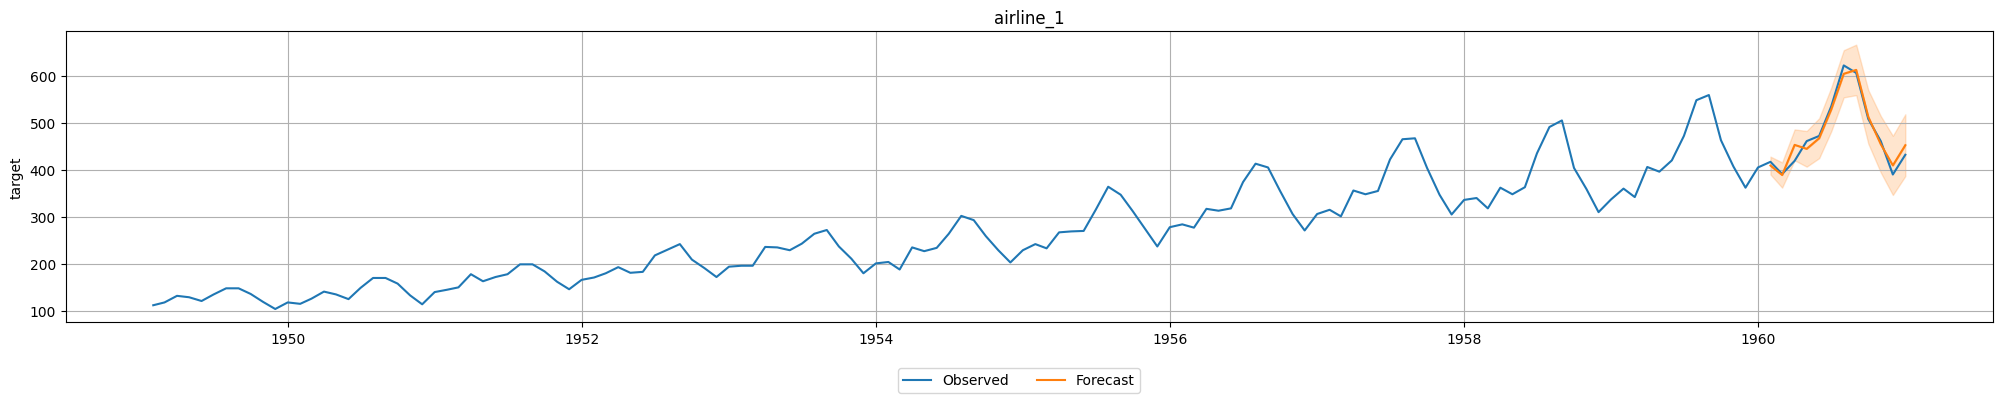

In [ ]:
predictor.plot(
    data=Y_df,
    predictions=predictions,
    item_ids=["airline_1"],
    max_history_length=200,
);